Read image acquired with mono-directional scan

In [2]:
from flopa.io.ptuio.reader import TTTRReader


reader = TTTRReader('../test_data/MultiHarp150_2025-06-18_16-37-45.274_f4_ch1_accu1__ch2_accu3_px500.ptu')
for key, value in reader.header.tags.items():
    print(f'{key}: {value}')


TTResult_StopReason: 0
File_Comment: N/A
File_CreatingTime: 2025-06-18 16:37:45.274000
CreatorSW_Name: Imspector
Measurement_Mode: 3
Measurement_SubMode: 3
$StartedByRemoteInterface: False
CreatorSW_Version: 16.3.21879-w2448
File_GUID: {0E01B9B7-36A1-4427-48AF-4FC29683E875}
Fast_Load_End: <Empty>
CreatorSW_SVNBuild: 21879
HW_Type: MultiHarp 150 4P
HW_Version: 1.0
HW_PartNo: 930043
HW_SerialNo: 1050703
HW_Features: 183
ImgHdr_Frame: 3
ImgHdr_LineStart: 1
ImgHdr_LineStop: 2
MeasDesc_AcquisitionTime: 6660
ImgHdr_PixX: 500
ImgHdr_PixY: 2000
ImgHdr_TimePerPixel: 0.005
UsrAI_usrTagVersion: 1.0.0
UsrAIScanAx_Label[0]: ExpControl X
ImgHdr_X0: -62.5
UsrAIScanAx_Label[1]: ExpControl Y
ImgHdr_Y0: -62.5
UsrAIScanAx_Label[2]: ExpControl Z
ImgHdr_Z0: -2.33
ImgHdr_PixResol: 0.25000000000000006
UsrAI_ScanAxes: 3
ImgHdr_BiDirect: False
ImgHdr_Dimensions: 3
ImgHdr_Ident: 13
HW_BaseResolution: 5e-12
MeasDesc_GlobalResolution: 2.5000081250264065e-08
MeasDesc_Resolution: 5e-12
MeasDesc_BinningFactor: 1
Mea

Here the image data is saved in the header, but accumulations and sequence configuration is not. So it must be known or guessed...

In [3]:

Measurement_SubMode = reader.header.tags.get("Measurement_SubMode")

if Measurement_SubMode<1: 
    print("Not an image. You must set scanning configuration.")
else:
    ImgHdr_PixX = reader.header.tags.get("ImgHdr_PixX")
    ImgHdr_PixY = reader.header.tags.get("ImgHdr_PixY")
    print("Number of pixels from header: ", ImgHdr_PixX)
    print("Number of lines from the header: ", ImgHdr_PixY)
    # Number of lines is only correct for 1 sequence + 1 accumulation


Number of pixels from header:  500
Number of lines from the header:  2000


Define scanning configuration and reconstruct image

In [4]:
from flopa.io.ptuio.utils import estimate_tcspc_bins
from flopa.io.ptuio.utils import T3OverflowCorrector
from flopa.io.ptuio.reconstructor import ScanConfig, ImageReconstructor

import numpy as np


cfg = ScanConfig(
    bidirectional=True, 
    frames= 3,
    lines=500, 
    pixels=500, 
    line_accumulations= (1,3),
    max_detector=2
    )

wrap = reader.header.tags.get("TTResultFormat_WrapAround", 1024)  # default fallback
repetition_rate = reader.header.tags.get("TTResult_SyncRate",40e6)  
tcspc_resolution = reader.header.tags.get("MeasDesc_Resolution",5e-12)
tcspc_bins = estimate_tcspc_bins(reader.header.tags,buffer=100) # for high resolution (<10ps), tcspcs channel overflow can be expected -> set higher buffer

corrector = T3OverflowCorrector(wraparound=wrap)
omega = 2 * np.pi * repetition_rate * tcspc_resolution # should be in channel units

reconstructor = ImageReconstructor(
        config=cfg, 
        omega=omega, 
        tcspc_channels= tcspc_bins,
        outputs=None # this will read everything
        )

for chunk in reader.iter_chunks():
    corrected_chunk = corrector.correct(chunk)
    reconstructor.update(corrected_chunk)

result = reconstructor.finalize()




TCSPC channel overflow detected! Max channel: 5104


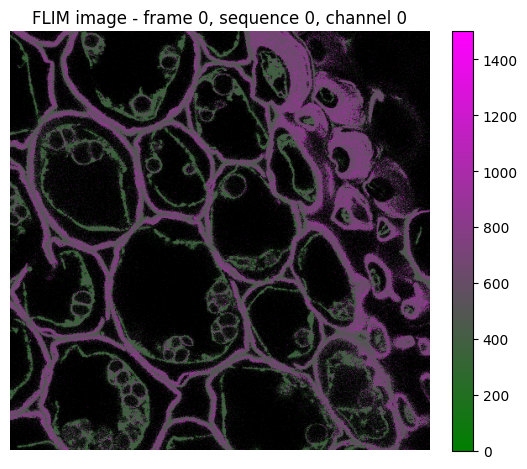

In [12]:
from flopa.io.ptuio.utils import create_FLIM_image
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
colormap = mcolors.LinearSegmentedColormap.from_list("green_red", ["green", "magenta"])

lt_min = 0
lt_max = 1500

FLIM_image = create_FLIM_image(mean_photon_arrival_time=result.mean_arrival_time.isel(frame=0,sequence=0,channel=0).values, 
                               intensity=result.photon_count.isel(frame=0,sequence=0,channel=0).values, 
                               lt_min = lt_min, 
                               lt_max = lt_max,
                               int_min=0,
                               int_max=10,
                               colormap=colormap
                               )

fig, ax = plt.subplots()
img = ax.imshow(FLIM_image, cmap = colormap,vmin=lt_min, vmax=lt_max)
ax.set_title('FLIM image - frame 0, sequence 0, channel 0')
ax.axis("off")
fig.colorbar(img, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

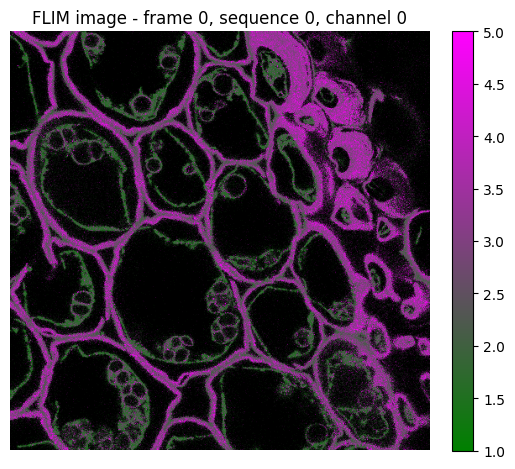

In [5]:
from flopa.io.ptuio.utils import create_FLIM_image
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
colormap = mcolors.LinearSegmentedColormap.from_list("green_red", ["green", "magenta"])

lt_min = 1 
lt_max = 5

FLIM_image = create_FLIM_image(mean_photon_arrival_time=result.mean_arrival_time.isel(frame=0,sequence=0,channel=0).values * tcspc_resolution * 1e9, 
                               intensity=result.photon_count.isel(frame=0,sequence=0,channel=0).values, 
                               lt_min = lt_min, 
                               lt_max = lt_max,
                               int_min=0,
                               int_max=10,
                               colormap=colormap
                               )

fig, ax = plt.subplots()
img = ax.imshow(FLIM_image, cmap = colormap,vmin=lt_min, vmax=lt_max)
ax.set_title('FLIM image - frame 0, sequence 0, channel 0')
ax.axis("off")
fig.colorbar(img, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

In [ ]:
result.tcspc_histogram

<xarray.DataArray 'tcspc_histogram' (frame: 3, channel: 2, tcspc_channel: 5101)> Size: 245kB
array([[[27, 39, 28, ...,  0,  0,  0],
        [ 4,  4,  4, ...,  0,  0,  0]],

       [[22, 31, 30, ...,  0,  0,  0],
        [ 3,  4,  5, ...,  0,  0,  0]],

       [[24, 27, 31, ...,  0,  0,  0],
        [ 3,  3,  4, ...,  0,  0,  0]]], shape=(3, 2, 5101), dtype=uint64)
Coordinates:
  * frame          (frame) int64 24B 0 1 2
  * channel        (channel) int64 16B 0 1
  * tcspc_channel  (tcspc_channel) int64 41kB 0 1 2 3 4 ... 5097 5098 5099 5100

: 

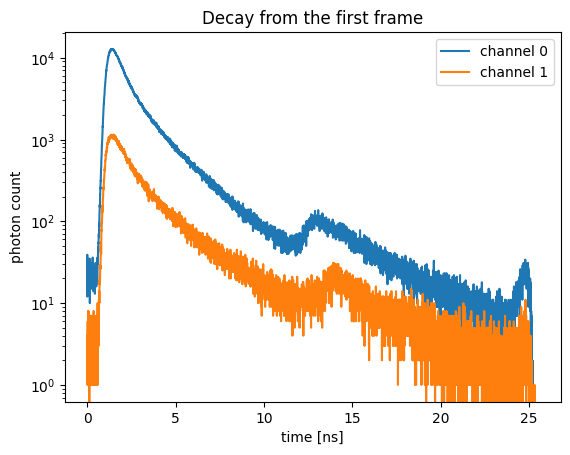

In [6]:
dtimes = result.tcspc_channel.values * tcspc_resolution * 1e9
fig, ax = plt.subplots()
ax.semilogy(dtimes,result.tcspc_histogram.isel(frame=0,channel=0).values)
ax.semilogy(dtimes,result.tcspc_histogram.isel(frame=0,channel=1).values)
ax.set_xlabel('time [ns]')
ax.set_ylabel('photon count')
ax.legend({
    'channel 0',
    'channel 1'
})
plt.title("Decay from the first frame")
plt.show()